In [15]:
#for data handling
import numpy as np
import pandas as pd

In [48]:
# file is in letor dataset format
#converting data from standard format(data of all queries should be together) 
data=pd.read_csv("interface/uploadedFiles/MyFile8.txt",sep=" ", header=None)
datasets={}
qid='qid:-1'
counter=0
for row in data.values:
  if qid!=row[1]:
    counter=0
  counter=counter+1
  qid=row[1]
#   print(row)
  l=len(row)
  row_data=[row[l-1]]
  for i in row[2:l-3]:
    # print(i)
    row_data.append(float(i.split(":")[1]))
  x_df = pd.DataFrame([row_data],columns=['doc_id','verified', 'Img_present', 'url_bool',
       'hashtag_bool', 'followers_count', 'friends_count', 'listed_count',
       'likes', 'comments', 'retweets', 'sum_followers_mention', 'url_count',
       'how_old', 'cosine', 'jaccard', 'hashtag_count', 'dice', 'word_count',
       'char_count', 'follower_friend_relation', 'tfidf_similarity', 'okapi'])
  y_df = pd.DataFrame([[float(row[0]),counter]],columns=['label','score'])
  if qid in datasets.keys():
    datasets[qid]['X']=pd.concat([datasets[qid]['X'], x_df], ignore_index=True)
    datasets[qid]['Y']=pd.concat([datasets[qid]['Y'], y_df], ignore_index=True)
  else:
    datasets[qid]={'X':x_df,'Y':y_df}
for key in datasets.keys():
  curr_df=datasets[key]['Y']['score']
  maxi=curr_df.max()
  mini=curr_df.min()
  datasets[key]['Y']['score']=[(maxi-score)/(maxi-mini) for score in curr_df]

In [52]:
a=0
b=150
combined_data_numerical_feature=pd.DataFrame([])
combined_data_categorical_feature=pd.DataFrame([])
combined_data_output=pd.DataFrame([])
for key in datasets.keys():
  curr_cate=datasets[key]['X'][['verified', 'Img_present', 'url_bool','hashtag_bool']]
  curr_nume=datasets[key]['X'][['followers_count', 'friends_count', 'listed_count',
       'likes', 'comments', 'retweets', 'sum_followers_mention', 'url_count',
       'how_old', 'cosine', 'jaccard', 'hashtag_count', 'dice', 'word_count',
       'char_count', 'follower_friend_relation', 'tfidf_similarity', 'okapi']]
  curr_output=datasets[key]['Y']
  print(len(combined_data_numerical_feature))
  if combined_data_numerical_feature.empty:
    combined_data_numerical_feature=curr_nume[a:b]
    combined_data_categorical_feature=curr_cate[a:b]
    combined_data_output=curr_output[a:b]
  else:
    combined_data_numerical_feature=pd.concat([combined_data_numerical_feature, curr_nume[a:b]], ignore_index=True)
    combined_data_categorical_feature=pd.concat([combined_data_categorical_feature, curr_cate[a:b]], ignore_index=True)
    combined_data_output=pd.concat([combined_data_output, curr_output[a:b]], ignore_index=True)

0
150
300
450
600
750
900
1050
1200
1350
1500


In [53]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif,chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def filterBasedFeatureSelection(filter_type,X, y, X_type, y_type, top_k=None):
  #this function print the score for top_k features and return the list of top_k features is deacreasing order
  if top_k==None:
    top_k=X.shape[1]
  if filter_type=='Univariate Selection':
    # Filter based-1. Univariate Selection
    if X_type=='num' and y_type=='num':
      score_function=f_regression
    elif X_type=='num' and y_type=='cat':
      score_function=f_classif
    elif X_type=='cat' and y_type=='cat':
      score_function=chi2
    else:
      print("type or combination mentioned is not allowed")
      return
    bestfeatures = SelectKBest(score_func=score_function, k=top_k)
    fit = bestfeatures.fit(X, y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    top_k_feature_metric=featureScores.nlargest(top_k,'Score')
    print(top_k_feature_metric)
    return list(top_k_feature_metric['Specs'].values) 
  elif filter_type=='Feature Importance':
    model = ExtraTreesClassifier()
    model.fit(X,y)
    # print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    print(feat_importances.nlargest(10))
    feat_importances.nlargest(10).plot(kind='barh')
    # plt.show()
    plt.savefig("featImportance.png")
    return list(feat_importances.nlargest(10).to_frame().index)
  elif filter_type=='Correlation Matrix':
    # Filter based-3. Correlation Matrix with Heatmap
    data=pd.concat([X,y],axis=1)
    corrmat = data.corr()#get correlations of each features in dataset
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
    plt.savefig("heatMap.png")
    print(corrmat['score'][corrmat['score'].abs().nlargest(top_k).index][1:])
    return list(corrmat['score'].abs().nlargest(top_k)[1:].index)
    # return corrmat
  else:
    print("no such filter based method available")

In [47]:
len(combined_data_numerical_feature)

2393

In [56]:
a=0
b=150
while a<1500:
    b=a+150
    filterBasedFeatureSelection('Univariate Selection',combined_data_numerical_feature[a:b], combined_data_output['score'][a:b],'num','num')
    a=a+150
    # filterBasedFeatureSelection('Univariate Selection',combined_data_numerical_feature, combined_data_output['label'],'num','cat',11)
# filterBasedFeatureSelection('Univariate Selection',combined_data_categorical_feature, combined_data_output['label'],'cat','cat')

                       Specs      Score
5                   retweets  29.161938
3                      likes  21.928393
9                     cosine  20.793097
4                   comments  19.123196
12                      dice  16.758085
10                   jaccard  15.290338
17                     okapi  13.379225
16          tfidf_similarity   7.352342
8                    how_old   6.297624
13                word_count   3.960627
15  follower_friend_relation   3.960627
11             hashtag_count   3.512781
0            followers_count   1.905053
14                char_count   1.595048
2               listed_count   1.282565
7                  url_count   0.896680
6      sum_followers_mention   0.091876
1              friends_count   0.054967
                       Specs       Score
8                    how_old  189.025643
11             hashtag_count   10.619068
6      sum_followers_mention    9.578103
3                      likes    5.849722
5                   retweets    5.0

how_old                    -0.231180
okapi                      -0.100271
word_count                 -0.097015
follower_friend_relation   -0.097015
sum_followers_mention       0.086828
url_count                   0.083037
jaccard                     0.073511
dice                        0.068508
char_count                 -0.067889
hashtag_count               0.064565
listed_count                0.055531
friends_count               0.043214
likes                      -0.042137
comments                   -0.035008
cosine                      0.033524
followers_count             0.029834
retweets                   -0.025125
Name: score, dtype: float64


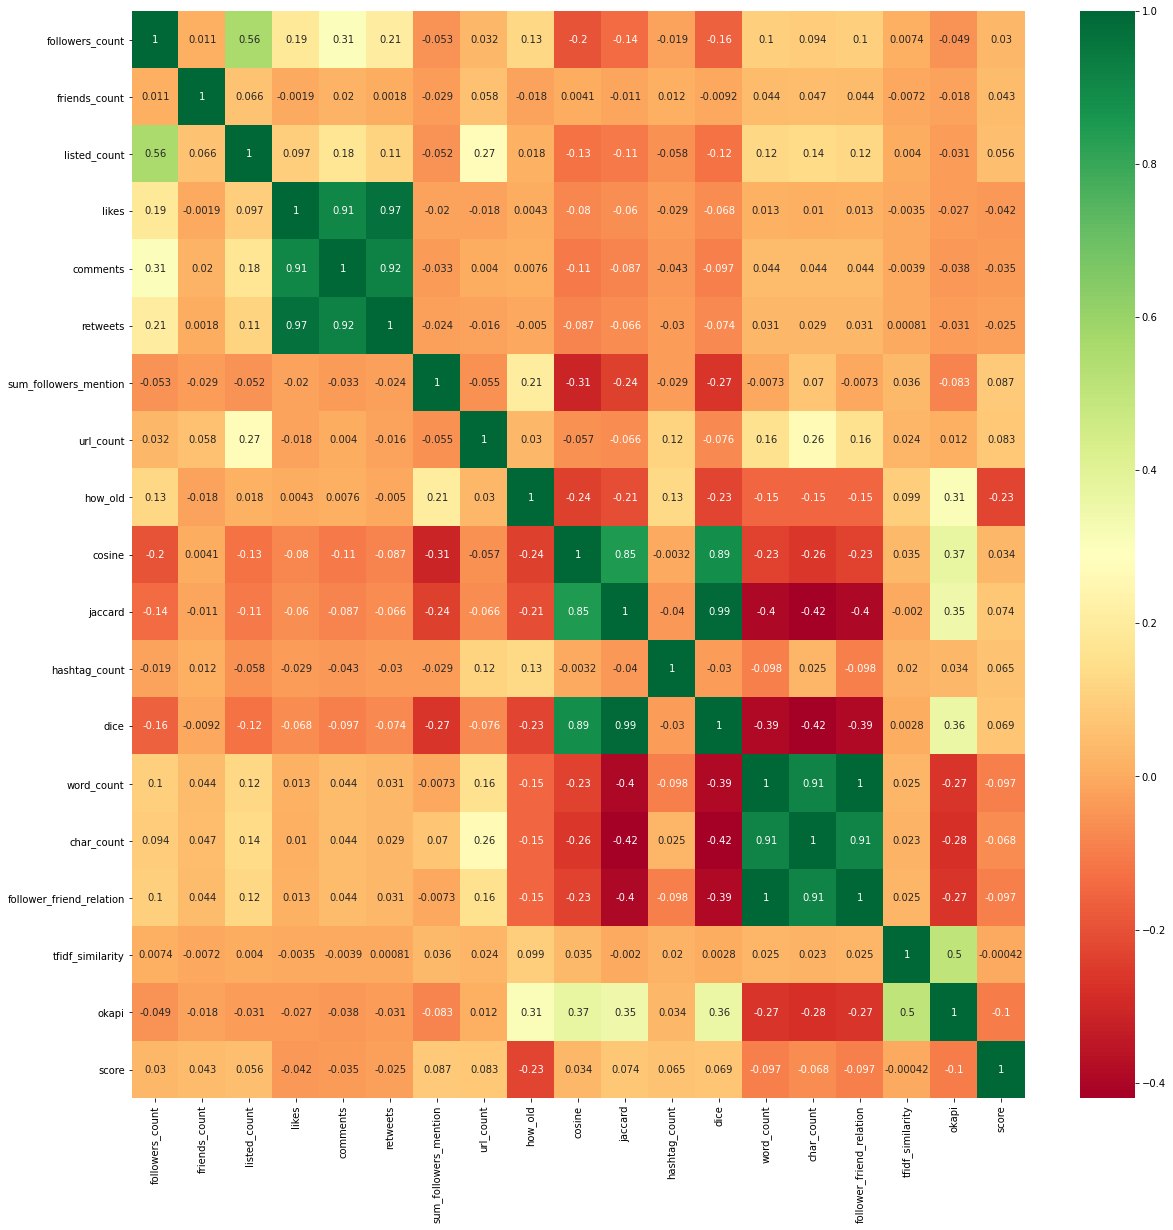

In [57]:
a=0
b=3000
X=filterBasedFeatureSelection('Correlation Matrix',combined_data_numerical_feature[a:], combined_data_output['score'][a:],'num','num')

In [ ]:
#https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7
#Wrapper-based-Recursive Feature Elimination
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
# create the RFE model for the svm classifier and select attributes
rfe_selector = RFE(estimator=LinearSVC(), n_features_to_select=3)
rfe_selector = rfe_selector.fit(combined_data_categorical_feature, combined_data_output['label'])

rfe_selector1 = RFE(estimator=LinearSVC(), n_features_to_select=18)
rfe_selector1 = rfe_selector1.fit(combined_data_numerical_feature, combined_data_output['label'])

# print summaries for the selection of attributes
print(combined_data_numerical_feature.columns)
print(rfe_selector1.support_)
print(rfe_selector1.ranking_)

print(combined_data_categorical_feature.columns)
print(rfe_selector.support_)
print(rfe_selector.ranking_)

In [ ]:
x=rfe_selector1.ranking_
y=list(combined_data_numerical_feature.columns)
dic={}
for i in range(0,len(x)):
  dic[x[i]]=y[i]
dic